**Kelvin Fung**<br>
**YSC4216 Machine Learning**<br>
**Assignment 2: Regression Using MAP and Basis Functions**

Link to assignment:
    
https://tanrobby.github.io/teaching/ync_machine_learning/assignment3.html

# Part 1: Full Bayesian Inference 

1. Generate 50 2D-data points using the following function: $y = sin(x^2 + 1)$
2. Add Gaussian random noise to the data
3. Show original curve line and the noisy data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

%matplotlib inline

In [2]:
# Functions to generate data
def actual_distribution(num_points=50):
    x_act = np.linspace(0, 1, num=num_points)
    y_act = np.sin(np.power(x_act, 2) + 1)
    
    return (x_act, y_act)

def add_noise(y_act, sig=.05):
    mu = 0
    noise = np.random.normal(mu, sig, len(y_act))
    
    return y_act + noise

In [3]:
x_act, y_act = actual_distribution(50)
y_noise = add_noise(y_act, .05)

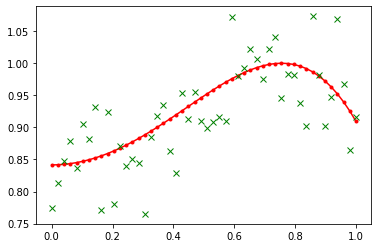

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x_act, y_act, '-ro', markersize=3, label='Original curve')
ax.plot(x_act, y_noise, '-gx', linestyle='none', label='Noisy data')

4. Compute w based on full Bayesian Inference (by using basis functions like discussed in class).
5. Display the estimated values of w

In [5]:
def gaussian_basis(x, miu, sigma):
        return np.exp(-np.power(x-miu, 2) / (2*np.power(sigma, 2)))

In [6]:
def full_bayesian(x_act, y_noise, M, basis_function, alpha=0, beta=1):
    
    s = 1 / M
    mu_values = [s*i for i in range(1, M)]
    
    phi = np.matrix([[1] + [basis_function(x, mu, s) for mu in mu_values]
                     for x in x_act])
    
    s_n = linalg.inv(np.diag([alpha for _ in range(M)]) + beta*phi.T*phi)
    
    m_n = beta * s_n * phi.T * np.matrix(y_noise).T
    
    y_est = phi*m_n
    
    return m_n, y_est

In [7]:
w, y_est = full_bayesian(x_act, y_noise, 5, gaussian_basis, .5, 5)

In [8]:
w

matrix([[ 0.77890224],
        [ 0.07572159],
        [-0.0151441 ],
        [ 0.08593882],
        [ 0.17072752]])

In [10]:
w, y_est = full_bayesian(x_act, y_noise, 5, gaussian_basis, .5, 20)
w

matrix([[ 0.81704703],
        [ 0.03968055],
        [-0.02493945],
        [ 0.08492882],
        [ 0.13092932]])

6. Experiment with your code by changing alpha and beta. Discuss the meaning of them with respect to the curve fitting results.

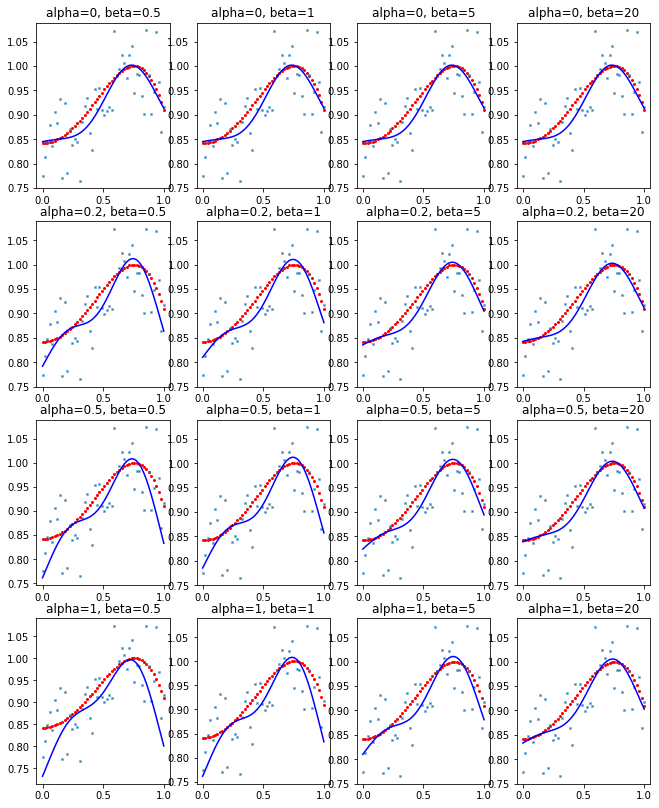

In [9]:
alpha_values = [0, 0.2, 0.5, 1]
beta_values = [0.5, 1, 5, 20]
plot_num = 1

fig = plt.figure(figsize=[11, 14])
for alpha in alpha_values:
    for beta in beta_values:
        _, y_est = full_bayesian(x_act, y_noise, 5, gaussian_basis, alpha, beta)
        
        ax = fig.add_subplot(4, 4, plot_num)
        plot_num += 1
        
        ax.plot(x_act, y_act, 'ro', markersize=2)   # Original curve
        ax.plot(x_act, y_noise, 'x', markersize=2)  # Noisy data
        ax.plot(x_act, y_est, 'b')                  # Fitted curve
        
        ax.set(title="alpha={}, beta={}".format(alpha, beta))

As we increase alpha, the curve seems to be more overfitted to the noisy data. We can understand this by looking at the equation, where the covariance matrix $S$ is inversely proportional to alpha. This means that as we increase alpha, we are allowing $w$ to have more variability around the mean 0, and hence the predicted curve may be overfitted.

As we increase beta, we seem to solve the overfitting problem.

7. Show your best fitting:

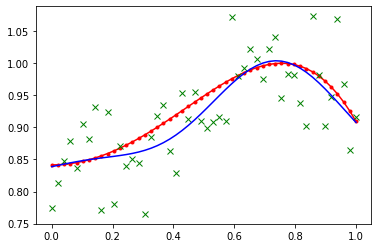

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x_act, y_act, '-ro', markersize=3, label='Original curve')
ax.plot(x_act, y_noise, '-gx', linestyle='none', label='Noisy data')
ax.plot(x_act, y_est, 'b', label='Predicted curve')

8. Increase the value of M, and discuss how it affects the prediction (curve fitting) and the uncertainty of the prediction.

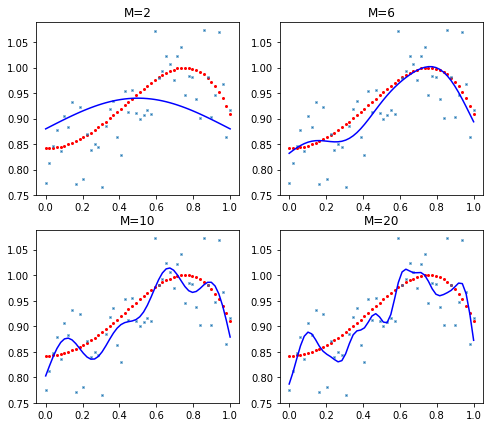

In [12]:
M_values = [2, 6, 10, 20]
plot_num = 1

fig = plt.figure(figsize=[8, 7])
for M in M_values:
    
    _, y_est = full_bayesian(x_act, y_noise, M, gaussian_basis, .5, 10)
    
    ax = fig.add_subplot(2,2, plot_num)
    plot_num += 1
        
    ax.plot(x_act, y_act, 'ro', markersize=2)   # Original curve
    ax.plot(x_act, y_noise, 'x', markersize=2)  # Noisy data
    ax.plot(x_act, y_est, 'b')                  # Fitted curve

    ax.set(title="M={}".format(M))

At M=2, the predicted curve does not fit well into the underlying curve. At M=10 and M=20, we observe overfitting, where the predicted curve tries to fit the noisy data too closely. At M=6, however, we obtain a predicted curve that fits the underlying curve decently well.

9. Explain how useful p(w|t) is for the training and testing stages.

$p(w|t)$ is useful in the training stage as it tells us how certain or uncertain we are about *w*, which are parameters of the model

# Part 2 - Sequential Bayesian Learning

1. Generate 50 2D-data points using the following function: $y = sin(x^2 + 1)$
2. Add Gaussian random noise to the data

In [13]:
x_act, y_act = actual_distribution(50)
y_noise = add_noise(y_act, .05)

3. Fit the generated noisy data sequentially (5 data for each sequence).

In [14]:
def sequential_bayesian(x_act, y_noise, M, basis_function, alpha=0, beta=1):
    
    # Create array to store order in which data is sampled.
    sampling_order = [x for x in range(50)]
    np.random.shuffle(sampling_order)
    
    s_lst = []
    w_lst = []
    y_est_lst = []
    
    s = 1 / M
    mu_values = [s*i for i in range(1, M)]
    PHI = np.matrix([[1] + [basis_function(x, mu, s) for mu in mu_values]
                     for x in x_act])

    # First set (regular Full Bayesian)
    x_subset = [x_act[i] for i in sampling_order[:5]]
    y_subset = [y_noise[i] for i in sampling_order[:5]]
    
    phi = np.matrix([[1] + [basis_function(x, mu, s) for mu in mu_values]
                     for x in x_subset])
    
    s_n = linalg.inv(np.diag([alpha for _ in range(M)]) + beta*phi.T*phi)
    m_n = beta * s_n * phi.T * np.matrix(y_subset).T
    y_est = PHI*m_n
    
    s_lst.append(s_n)
    w_lst.append(m_n)
    y_est_lst.append(y_est)
    
    # Subsequent sets    
    sequence_num = 2
    while sequence_num <= 10:
        x_subset = [x_act[i] for i in sampling_order[(sequence_num-1)*5:(sequence_num*5)]]
        y_subset = [y_noise[i] for i in sampling_order[(sequence_num-1)*5:(sequence_num*5)]]

        phi = np.matrix([[1] + [basis_function(x, mu, s) for mu in mu_values]
                         for x in x_subset])
        
        s_n = linalg.inv(linalg.inv(s_lst[sequence_num-2]) + beta*phi.T*phi)
        m_n = s_n * (linalg.inv(s_lst[sequence_num-2]) * w_lst[sequence_num-2] + \
                     beta*phi.T*np.matrix(y_subset).T)
        y_est = PHI*m_n
        
        s_lst.append(s_n)
        w_lst.append(m_n)
        y_est_lst.append(y_est)
        
        sequence_num += 1
        
    return w_lst, y_est_lst

In [15]:
w_lst, y_est_lst = sequential_bayesian(x_act, y_noise, 6, gaussian_basis, 0.5, 5) 

4. Show your best result for each sequence. The below examples are only some of them, but in your submission, you have to show all m.

In [16]:
y_est_lst

[matrix([[0.78240298],
         [0.79609627],
         [0.80963189],
         [0.82261442],
         [0.83464387],
         [0.84534098],
         [0.85437316],
         [0.86147888],
         [0.86648823],
         [0.86933779],
         [0.87007848],
         [0.86887566],
         [0.8660015 ],
         [0.86182058],
         [0.85676988],
         [0.85133521],
         [0.84602587],
         [0.84134939],
         [0.83778825],
         [0.83577933],
         [0.83569719],
         [0.83784107],
         [0.84242565],
         [0.84957488],
         [0.85931837],
         [0.87158971],
         [0.88622634],
         [0.90297069],
         [0.92147293],
         [0.94129546],
         [0.96192015],
         [0.98275884],
         [1.00316792],
         [1.02246747],
         [1.03996498],
         [1.05498332],
         [1.06689165],
         [1.0751377 ],
         [1.0792791 ],
         [1.07901124],
         [1.07418889],
         [1.06483941],
         [1.05116572],
         [1

1
2
3
4
5
6
7
8
9
10


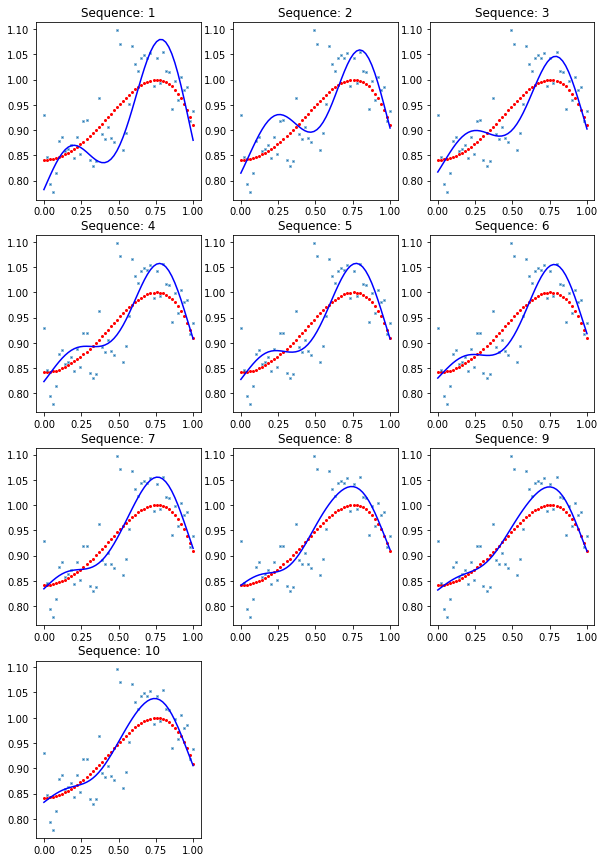

In [17]:
plot_num = 1

fig = plt.figure(figsize=[10, 15])
for y_est in y_est_lst:
    
    print(plot_num)
    ax = fig.add_subplot(4,3, plot_num)
    
    ax.plot(x_act, y_act, 'ro', markersize=2)   # Original curve
    ax.plot(x_act, y_noise, 'x', markersize=2)  # Noisy data
    ax.plot(x_act, y_est, 'b')                  # Fitted curve

    ax.set(title="Sequence: {}".format(plot_num))
    plot_num += 1

5. Discuss how to set M and the basis function's parameters in sequential learning.

The tradeoff in sequential learning is that it is difficult to set M and the basis function's parameters. If we are only given 5 data points in our first sequence, it is difficult for us to choose M and the basis function's parameters. If we have domain knowledge about the data (for e.g., in the house example, if we have a study done in a different city), perhaps we can make an educated guess. However, as more sequences come in, we may find that the chosen M and basis function's parameters do not work well. In that situation, if we still have access to all the previous sequences of data, we can set a different M and train the model again. However, depending on the scale of the data, this can be computationally expensive. Furthermore, it is not always the case that we will keep data from previous sequences.

# Part 3 - Predictive Distribution 

1. Generate 50 2D-data points using the following function: $y = sin(x^2 + 1)$
2. Add Gaussian random noise to the data
3. Show original curve line and the noisy data

In [18]:
x_act, y_act = actual_distribution(50)
y_noise = add_noise(y_act, .05)

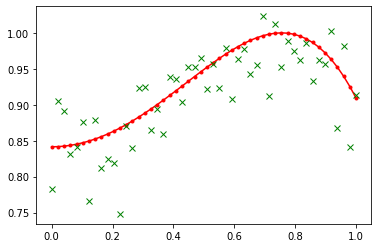

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x_act, y_act, '-ro', markersize=3, label='Original curve')
ax.plot(x_act, y_noise, '-gx', linestyle='none', label='Noisy data')

4. Compute the predictive distribution of every input data sequentially, where each input data is taken randomly from the noise data.

In [32]:
def predictive_dist(x_act, y_noise, M, basis_function, alpha=0, beta=1):
    
    # Create array to store order in which data is sampled.
    sampling_order = [x for x in range(50)]
    np.random.shuffle(sampling_order)
    print(sampling_order)
    
    s_lst = []
    w_lst = []
    y_est_lst = []
    y_error_lst = []
    
    s = 1 / M
    mu_values = [s*i for i in range(1, M)]
    PHI = np.matrix([[1] + [basis_function(x, mu, s) for mu in mu_values]
                     for x in x_act])
    
    def y_pred_and_error(x_act, w, sigma):

        y_pred = []
        error = []

        for x in x_act:
            phi_vec = np.matrix([1] + [basis_function(x, mu, s) for mu in mu_values]).T
            
            y_val = (w.T * phi_vec)
            error_val = (1/beta + phi_vec.T * sigma * phi_vec)
        
            y_pred.append(y_val.item())
            error.append(error_val.item())

        return y_pred, error
    
    for sequence, index in enumerate(sampling_order):
        
        # First sequence
        if sequence == 0:
            phi = np.matrix([1] + [basis_function(x_act[index], mu, s) for mu in mu_values])
    
            s_n = linalg.inv(np.diag([alpha for _ in range(M)]) + beta*phi.T*phi)
            m_n = beta * s_n * phi.T * np.matrix(y_noise[index])    

        # Subsequent sequences
        else:
            phi = np.matrix([[1] + [basis_function(x_act[index], mu, s) for mu in mu_values]])
            
            s_n = linalg.inv(linalg.inv(s_lst[sequence-1]) + beta*phi.T*phi)
            m_n = s_n * (linalg.inv(s_lst[sequence-1]) * w_lst[sequence-1] + \
                         beta*phi.T*np.matrix(y_noise[index]))
            
        y_pred, y_error = y_pred_and_error(x_act, m_n, s_n)
        s_lst.append(s_n)
        w_lst.append(m_n)
        y_est_lst.append(y_pred)
        y_error_lst.append(y_error) 
            
    return y_est_lst, y_error_lst    

In [33]:
y_est_lst, y_error_lst = predictive_dist(x_act, y_noise, 6, gaussian_basis, 0.5, 5) 

[47, 46, 42, 24, 48, 5, 14, 7, 29, 12, 21, 16, 49, 15, 6, 19, 44, 20, 36, 11, 9, 2, 40, 4, 33, 1, 31, 34, 0, 45, 28, 8, 10, 39, 3, 17, 38, 32, 37, 23, 22, 41, 35, 43, 18, 30, 13, 26, 25, 27]


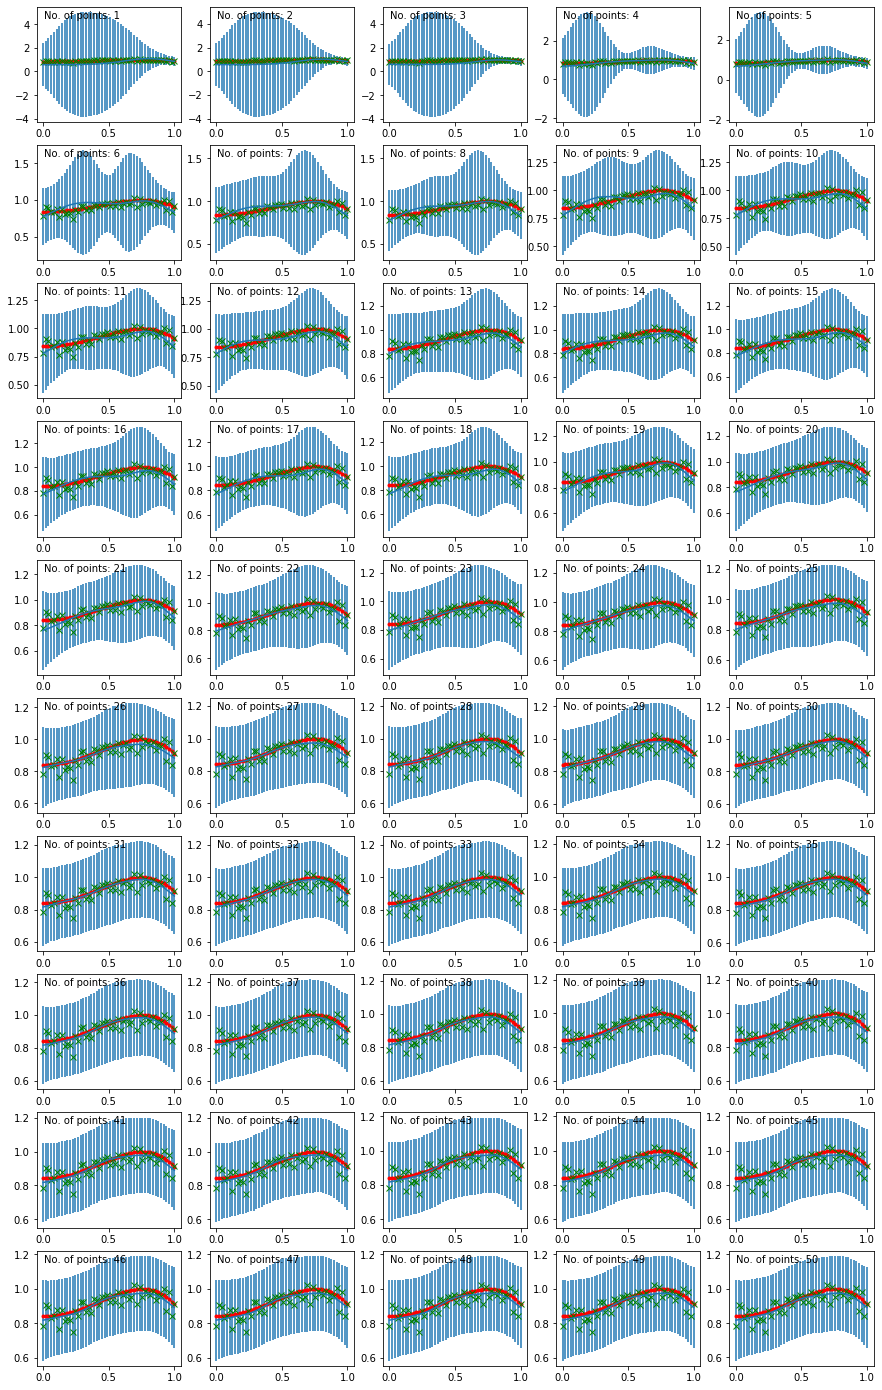

In [34]:
plot_num = 1

fig = plt.figure(figsize=[15, 25])

for y_est, y_error in zip(y_est_lst, y_error_lst):

    ax = fig.add_subplot(10, 5, plot_num)

    ax.plot(x_act, y_act, '-ro', markersize=3, label='Original curve')
    ax.plot(x_act, y_noise, '-gx', linestyle='none', label='Noisy data')
    ax.errorbar(x_act, y_est, yerr=y_error, label='Fitted curve')
    ax.text(0.05, 0.9, "No. of points: {}".format(plot_num), transform=ax.transAxes)
    plot_num += 1

5. Experiment with your code by changing beta, and explain what beta is for and how it affects the results.

In [35]:
y_est_lst2, y_error_lst2 = predictive_dist(x_act, y_noise, 6, gaussian_basis, 0.5, 20) 

[3, 11, 45, 29, 18, 39, 0, 49, 10, 2, 4, 12, 13, 32, 1, 20, 38, 22, 26, 19, 46, 24, 28, 17, 41, 30, 44, 23, 15, 34, 43, 16, 5, 9, 42, 25, 48, 27, 6, 35, 21, 36, 33, 14, 31, 40, 7, 37, 8, 47]


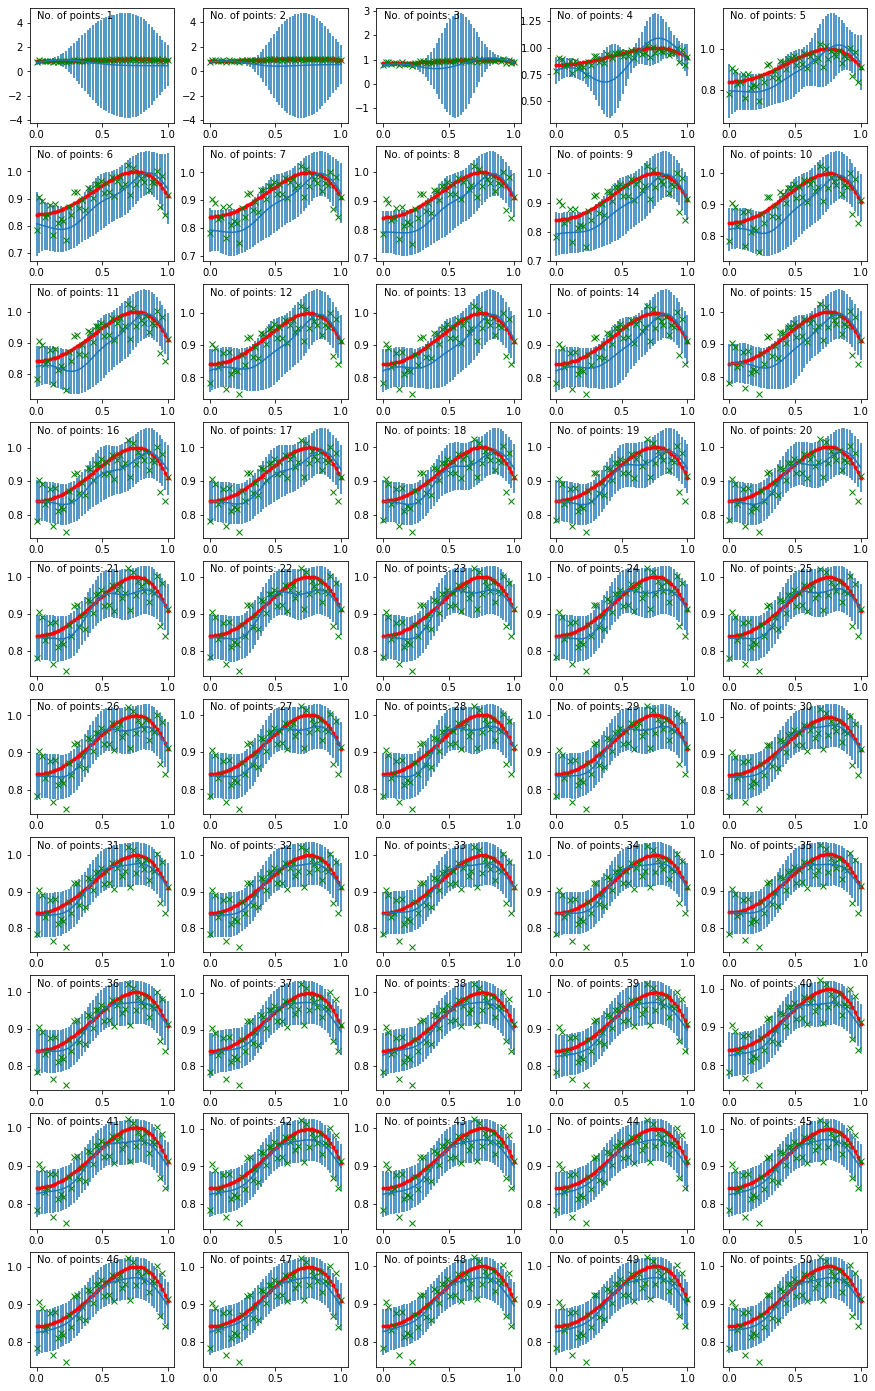

In [36]:
plot_num = 1

fig = plt.figure(figsize=[15, 25])

for y_est, y_error in zip(y_est_lst2, y_error_lst2):

    ax = fig.add_subplot(10, 5, plot_num)

    ax.plot(x_act, y_act, '-ro', markersize=3, label='Original curve')
    ax.plot(x_act, y_noise, '-gx', linestyle='none', label='Noisy data')
    ax.errorbar(x_act, y_est, yerr=y_error, label='Fitted curve')
    ax.text(0.05, 0.9, "No. of points: {}".format(plot_num), transform=ax.transAxes)
    plot_num += 1

From our discussion, we know that beta inverse is the variance of the likelihood Gaussian distribution, $p(t|w)$. In other words, the variability of the observed value around the mean value. Hence, when we set beta to a high value, beta inverse will be small, which means that we do not expect the observed value to be far from its mean. As we can see above, the when beta is increased to 20, the error bars are shorter and as a result many observed points were more than a standard deviation from their expected values. In the plots below, we will set beta = 5, which will give us longer error bars. Then, all of the observed points will be within one standard deviation from their expected values.

8. Discuss the differences between p(t_new|t) and p(w|t).

p(t_new|t) has the advantage in a practical setting, where we care about the prediction, but not the parameters or the underlying model.